
# Exploration Notebook
For initial experimentation

In [1]:
import os
import sys

import numpy as np

sys.path.append('externals/respinow_ml') # Fixes importing issues in external modules

from externals.respinow_ml.src.load_data import *
from externals.respinow_ml.src.plot_functions import *
import pandas as pd
import matplotlib.pyplot as plt
from darts.dataprocessing.transformers import StaticCovariatesTransformer
from sklearn.preprocessing import OneHotEncoder
from darts.utils.likelihood_models import QuantileRegression
from darts.utils.likelihood_models import NegativeBinomialLikelihood
from darts.dataprocessing.transformers import Scaler
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from darts.models import TSMixerModel
from darts.utils.callbacks import TFMProgressBar

import rich
import torch
from pytorch_lightning.callbacks import EarlyStopping, ModelSummary, LearningRateMonitor
from pytorch_lightning.loggers import WandbLogger
import wandb

from scipy.stats import nbinom
from externals.respinow_ml.src.scoring_functions import evaluate_models

from plotnine import ggplot, aes, geom_bar, geom_label, scale_alpha_manual, labs, coord_flip, theme_bw, theme, geom_line, scale_alpha_discrete, guide_legend, ggsave

from utils import MetricsLogger, reshape_backtest_likelihood_params, evaluate_model, get_covariates_dict

In [11]:
# Set the CUDA_VISIBLE_DEVICES environment variable to the first device
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'

# Load Data

In [2]:
ts = load_data(['survstat', 'icosari', 'agi', 'cvn'])
#ts['survstat-influenza-DE-BW'].plot()

survstat
- influenza
icosari
- sari
agi
- are
cvn
- influenza
- influenza-tests


# Static Covariates

In [3]:
ts.static_covariates.drop(columns=['source', 'target'], inplace=True)

covariates_transformer = StaticCovariatesTransformer(transformer_cat = OneHotEncoder())
ts = covariates_transformer.fit_transform(ts)

ts.static_covariates.head()

static_covariates,location_DE,location_DE-BB-BE,location_DE-BW,location_DE-BY,location_DE-HE,location_DE-MV,location_DE-NI-HB,location_DE-NW,location_DE-RP-SL,location_DE-SH-HH,...,location_DE-ST,location_DE-TH,age_group_00+,age_group_00-04,age_group_05-14,age_group_15-34,age_group_35-59,age_group_60+,age_group_60-79,age_group_80+
component,,,,,,,,,,,,,,,,,,,,,
survstat-influenza-DE,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
survstat-influenza-00-04,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
survstat-influenza-05-14,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
survstat-influenza-15-34,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
survstat-influenza-35-59,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


# Train Test Valid Split

In [4]:
train_end        = pd.Timestamp('2018-09-30')
validation_start = pd.Timestamp('2018-10-07')
validation_end   = pd.Timestamp('2019-09-29')
test_start       = pd.Timestamp('2019-10-06')
test_end         = pd.Timestamp('2020-09-27')

TARGETS = [t for t in ts.columns if 'survstat-influenza' in t] # The 19 time series we want to predict
targets, covariates = target_covariate_split(ts, TARGETS) # Split into targets and covariates

<Axes: xlabel='date'>

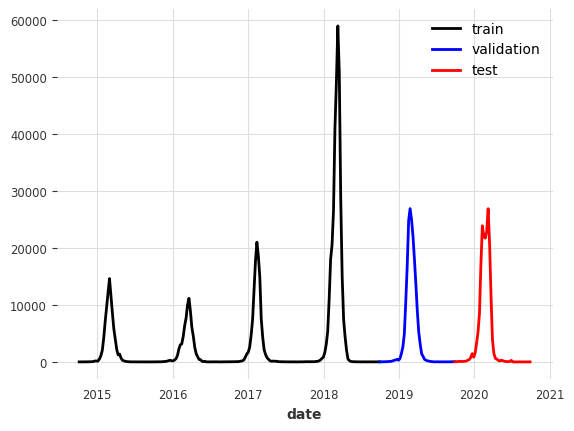

In [5]:
targets[ : train_end]['survstat-influenza-DE'].plot(label='train')
targets[train_end : validation_end]['survstat-influenza-DE'].plot(label='validation', color='b')
targets[validation_end : test_end]['survstat-influenza-DE'].plot(label='test', color='r')
#plt.savefig('plots/survstat-influenza-DE.pdf', format="pdf", bbox_inches="tight")

<Axes: xlabel='date'>

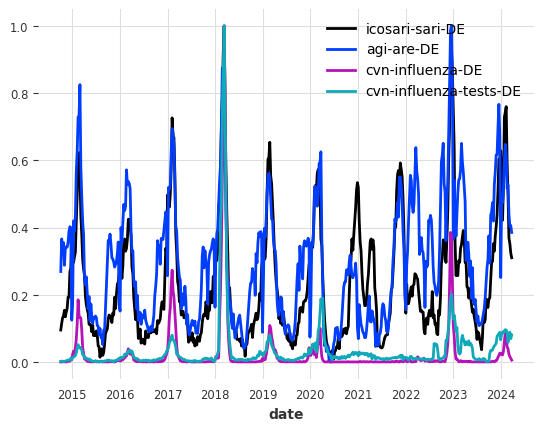

In [6]:
component_DE = [component for component in covariates.columns if 'DE' in component]
scaler = Scaler(MinMaxScaler(feature_range=(0, 1)), global_fit=False)
covariates_scaled = scaler.fit_transform(covariates)
covariates_scaled[component_DE].plot()
#plt.savefig('plots/covariates-DE.pdf', format="pdf", bbox_inches="tight")

# TSMixer Model

## Scaler
Scale the series to have zero mean and unit variance or alternatively use a MinMaxScaler.  
Each series is scaled independently.

In [7]:
SCALE = False

if SCALE:
    scaler = Scaler(MinMaxScaler(feature_range=(0.0001, 1)), global_fit=False) # Scale the data using a Scaler from sklearn
    scaler.fit(targets[ : train_end]) # Fit the scaler to the training data
    targets = scaler.transform(targets) # Transform the data

## Further covariates
Read [SequentialEncoders](https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#sequentialencoder)

In [13]:
encoders = {
    'cyclic': {'future': ['month', 'weekofyear']},
    #'transformer': Scaler()
}

In [14]:
USE_COVARIATES = False

## Model specification

In [21]:
#QUANTILES = [0.025, 0.25, 0.5, 0.75, 0.975]
#likelihood_model = QuantileRegression(quantiles=QUANTILES)
#logger = WandbLogger(project='tsmixer')
#logger.experiment.config["scaler"] = scaler.transformer.__class__.__name__
tsmixer = TSMixerModel(input_chunk_length=40, #40
                       output_chunk_length=4,
                       likelihood=NegativeBinomialLikelihood(),
                       #likelihood=likelihood_model,
                       use_static_covariates=True,
                       hidden_size=128, #128
                       ff_size=64, #64
                       num_blocks=2,
                       dropout=0.05,
                       batch_size=16,
                       n_epochs=200,
                       add_encoders = encoders,
                       save_checkpoints=True,
                       optimizer_cls=torch.optim.Adam,
                       optimizer_kwargs={'lr': 0.0001}, 
                       lr_scheduler_cls=torch.optim.lr_scheduler.ReduceLROnPlateau,
                       lr_scheduler_kwargs={'factor': 0.5, 'patience': 10, 'threshold': 1e-4},
                       pl_trainer_kwargs={
                           #"logger": logger,
                           "accelerator" : "gpu",
                           "devices": 1,
                           "enable_progress_bar" : True,
                           "enable_model_summary" : False,
                           "enable_checkpointing" : True,
                           "log_every_n_steps": 10,
                           "callbacks" : [ModelSummary(max_depth=2),
                                          TFMProgressBar(enable_sanity_check_bar=False,
                                                         enable_validation_bar=False
                                                         ),
                                          EarlyStopping(monitor="val_loss",
                                                        patience=20,
                                                        min_delta=1e-5,
                                                        mode="min",
                                                        ),
                                          MetricsLogger(),
                                          ]
                       })

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

   | Name                              | Type                   | Params
------------------------------------------------------------------------------
0  | criterion                         | MSELoss                | 0     
1  | train_metrics                     | MetricCollection       | 0     
2  | val_metrics                       | MetricCollection       | 0     
3  | fc_hist                           | Linear                 | 164   
4  | feature_mixing_hist               | _FeatureMixing         | 14.0 K
5  | feature_mixing_hist.projection    | Linear                 | 3.1 K 
6  | feature_mixing_hist.norm_before   | Identity               | 0     
7  | feature_mixing_hist.fc1           | Linear                 | 1.5 K 
8  | feature_mixing_hist.activation    | ReLU                   | 0

Training: 0it [00:00, ?it/s]

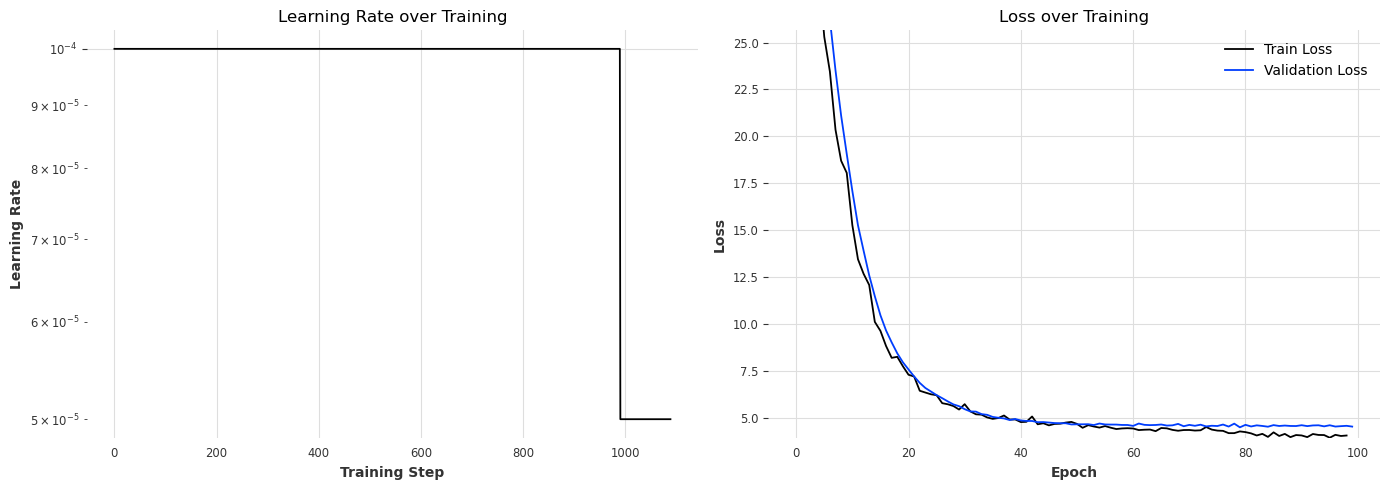

In [22]:
training_series = targets[:train_end]
# Val Series should start at validation_start - input_chunk_length so every unseen value is predicted
val_series = targets[validation_start - tsmixer.input_chunk_length * targets.freq:validation_end]
covariates_dict_train, covariates_dict_val = get_covariates_dict(USE_COVARIATES,
                                                                 covariates)

tsmixer.fit(series = training_series,
            val_series = val_series,
            **covariates_dict_train
            )
tsmixer = TSMixerModel.load_from_checkpoint(model_name=tsmixer.model_name, best=True)

# Model Evaluation
## Validation
Comupte the WIS, spread, overprediction, underprediction, c50 and c95 for the validation period.

In [23]:
_, df = evaluate_model(model=tsmixer,
                       targets=targets,
                       start=validation_start,
                       end=validation_end,
                       covariates=covariates_dict_val,
                       deterministic=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

                         TSMixerModel Evaluation Metrics                          
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Metric          ┃           National ┃              State ┃                Age ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Wis             │  500.4359693877551 │  92.40979323308271 │  86.62042517006803 │
│ Spread          │ 139.61147959183677 │ 27.381275510204087 │ 28.906989795918374 │
│ Overprediction  │ 32.083673469387755 │ 12.842857142857143 │ 13.242176870748299 │
│ Underprediction │  328.7408163265306 │ 52.185660580021484 │  44.47125850340136 │
│ C50             │ 0.4489795918367347 │ 0.5413533834586466 │ 0.5365646258503401 │
│ C95             │ 0.8979591836734694 │ 0.9242749731471536 │ 0.9209183673469388 │
└─────────────────┴────────────────────┴────────────────────┴────────────────────┘

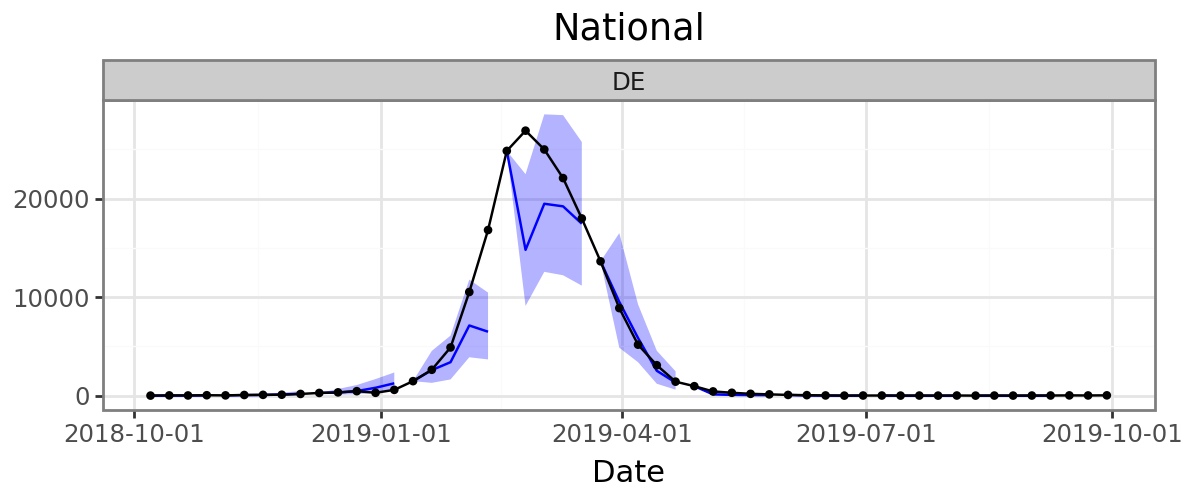

In [24]:
df_plot = prepare_plot_data(df, targets[validation_start:validation_end])
p = plot_forecasts(df_plot, 'national') # Startum can be 'states', 'age' or 'national'
#p.save('pred_age_4.pdf')
p

## Test

In [20]:
hfc, df = evaluate_model(model=tsmixer,
                         targets=targets,
                         start=test_start,
                         end=test_end,
                         covariates=covariates_dict_val,
                         deterministic=True)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


Predicting: 0it [00:00, ?it/s]

                         TSMixerModel Evaluation Metrics                          
┏━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┓
┃ Metric          ┃           National ┃              State ┃                Age ┃
┡━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━┩
│ Wis             │   856.276530612245 │ 152.33468313641248 │ 161.11505952380952 │
│ Spread          │   503.530612244898 │  77.39977443609024 │  79.92169217687075 │
│ Overprediction  │  84.38163265306123 │ 26.058378088077337 │  29.01003401360544 │
│ Underprediction │  268.3642857142857 │   48.8765306122449 │  52.18333333333333 │
│ C50             │ 0.5459183673469388 │ 0.5700859291084855 │ 0.5348639455782312 │
│ C95             │ 0.9693877551020408 │ 0.9403866809881848 │ 0.9217687074829932 │
└─────────────────┴────────────────────┴────────────────────┴────────────────────┘

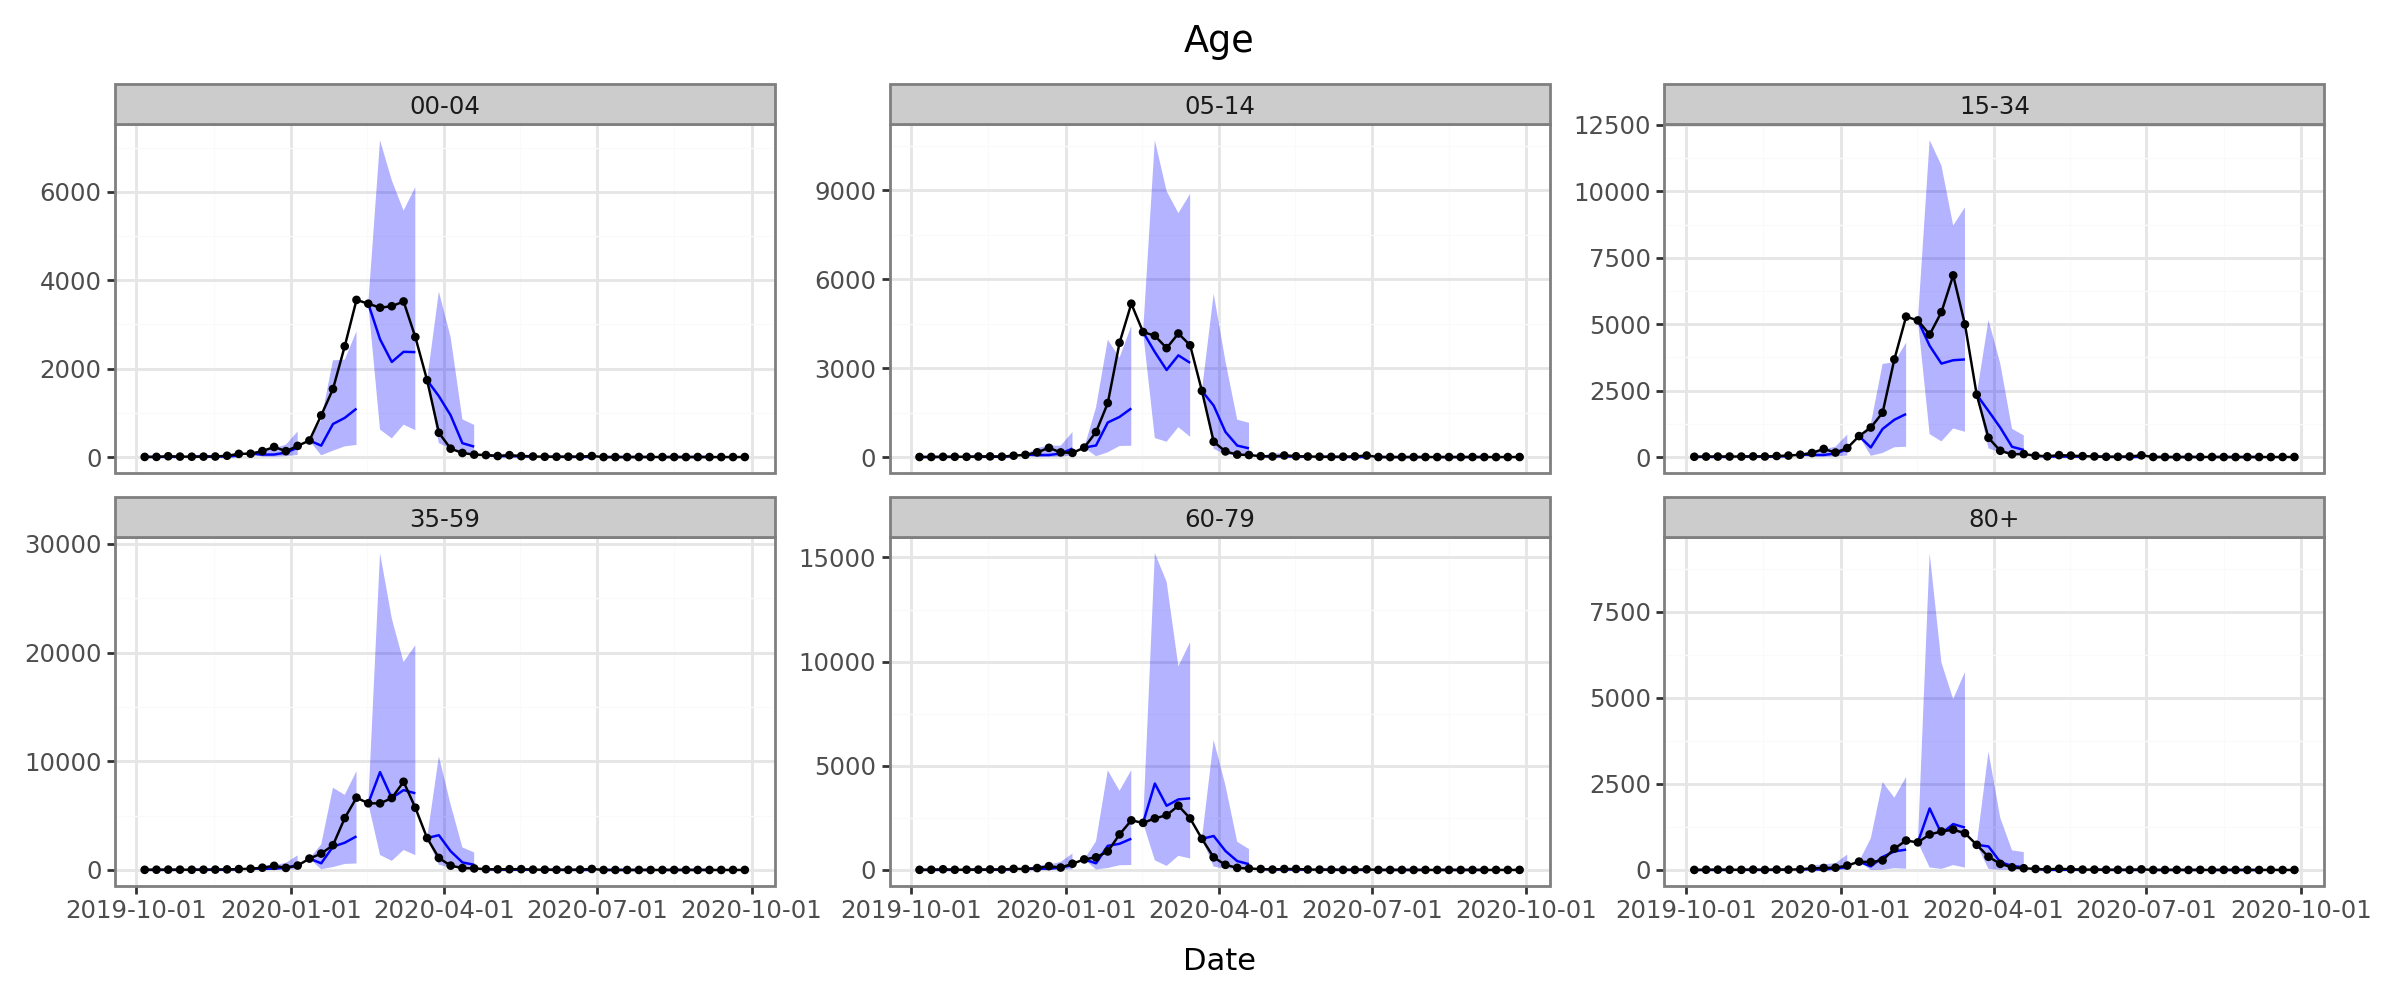

In [21]:
df_plot = prepare_plot_data(df, targets[test_start:test_end])
p = plot_forecasts(df_plot, 'age') # Startum can be 'states', 'age' or 'national'
#p.save('plots/forecast_age.pdf')
p

# Scoring

In [112]:
# Save the backtest
df.to_csv('externals/respinow_ml/data/pre-covid/test_TSMixer.csv', index=False)

In [113]:
def load_predictions(disease='influenza', period='validation', include_median=True, include_truth=True):
    files = glob.glob(f'externals/respinow_ml/data/pre-covid/{period}*.csv') # TODO choose disease
    dfs = []
    for file in files:
        df_temp = pd.read_csv(file)
        df_temp['model'] = file.split('_')[-1][:-4]
        dfs.append(df_temp)
    df = pd.concat(dfs)
    
    if include_median:
        df = add_median(df)
    if include_truth:
        df = add_truth(df, disease)

    return df

In [114]:
df_eval = load_predictions(disease='influenza', period='test', include_median=True, include_truth=True)

## National

In [115]:
evaluate_models(df_eval, 'national')

,model,spread,overprediction,underprediction,wis,c50,c95
0,TSMixer,413.102398,163.659184,357.653061,934.414643,0.479592,0.923469
1,lgbm-global,474.968631,183.316095,532.053097,1190.337822,0.484694,0.918367
2,arima,700.811670,517.439978,312.558031,1530.809680,0.346939,0.801020
3,tft,36.693011,173.432856,1417.594431,1627.720298,0.122449,0.326531
4,baseline,0.000000,1270.734694,1268.408163,2539.142857,0.000000,0.000000
5,lgbm,97.579667,0.804637,2466.943415,2565.327719,0.290816,0.744898


## States

In [116]:
evaluate_models(df_eval, 'states')

,model,spread,overprediction,underprediction,wis,c50,c95
0,TSMixer,41.376552,17.195068,31.235884,89.807504,0.619898,0.952806
1,lgbm-global,33.149365,25.807595,50.799101,109.756060,0.395408,0.849065
2,arima,61.898113,28.389539,50.281466,140.569118,0.456207,0.889456
3,tft,4.879738,23.950777,130.515217,159.345732,0.223214,0.557823
4,lgbm,92.853509,30.455465,52.952822,176.261796,0.795918,0.992347
5,baseline,0.000000,115.639881,115.446003,231.085884,0.152211,0.152211


## Age

In [117]:
evaluate_models(df_eval, 'age')

,model,spread,overprediction,underprediction,wis,c50,c95
0,TSMixer,79.732509,23.169388,49.530102,152.431998,0.519558,0.924320
1,lgbm-global,65.534289,41.500679,92.080509,199.115477,0.465136,0.863095
2,lgbm,93.087206,13.157436,166.568938,272.813580,0.693027,1.000000
3,arima,129.778575,69.813982,80.324193,279.916750,0.402211,0.878401
4,tft,9.521591,43.262774,230.260543,283.044907,0.165816,0.437075
5,baseline,0.000000,216.165816,215.778061,431.943878,0.062925,0.062925


## Plots

/home/feik/.conda/envs/tsmixer/lib/python3.11/site-packages/plotnine/scales/scale_alpha.py:76: PlotnineWarning: Using alpha for a discrete variable is not advised.


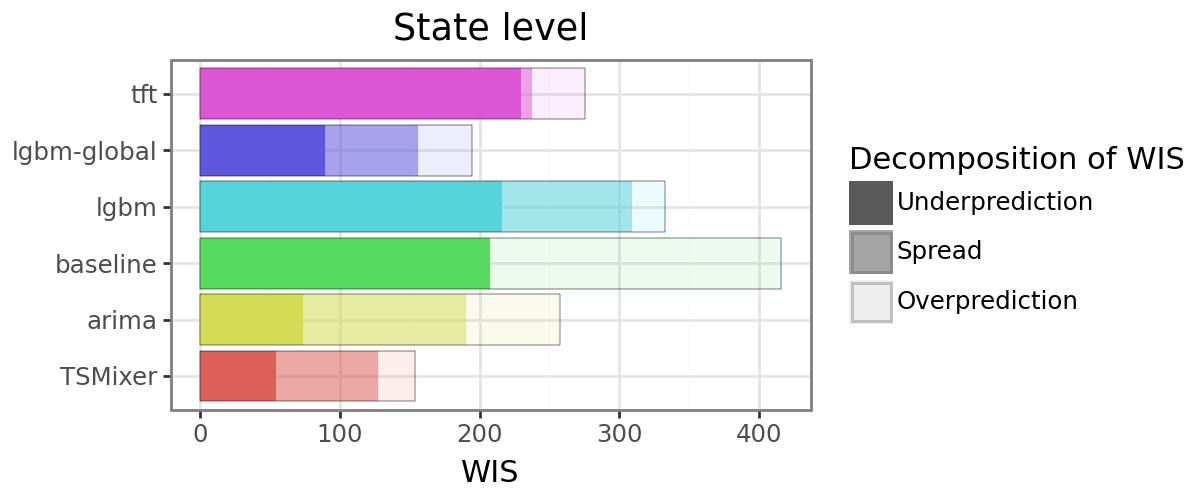

In [129]:
level = 'state'
df = evaluate_models(df_eval, level=level)
scores = pd.melt(df, id_vars=['model'], value_vars=['underprediction', 'spread', 'overprediction'], 
                 var_name='penalty', value_name='value')
p = ((ggplot()
    + geom_bar(scores, aes(x='model', y='value', fill='model', alpha='penalty', color='model'), size=0.01, stat='identity', 
               show_legend={'color': False,
                            'fill': False,
                            'alpha': True})
    + geom_bar(df, aes(x='model', y='wis'), fill=None, color='black', size=0.1, stat='identity')
    + scale_alpha_discrete(labels=["Overprediction", "Spread", "Underprediction"], guide=guide_legend(reverse=True))
    + labs(x="", y="WIS", color="Model", alpha="Decomposition of WIS", title=f"{level.capitalize()} level")
    + coord_flip()
    + theme_bw()
    + theme(legend_position='right')
    ))
p

In [130]:
p.save(f'plots/{level}.pdf')

/home/feik/.conda/envs/tsmixer/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 2.5 in image.
/home/feik/.conda/envs/tsmixer/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: plots/state.pdf
